<a href="https://colab.research.google.com/github/Skruller01/external_file/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#06. Pytorch Transfer learning

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
import zipfile
from pathlib import Path
import requests

#Setup data path
data_path=Path("data")
image_path=data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print("The directory already exists")
else:
  print(f"Did not find {image_path} directory,creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi.zip...")
    f.write(request.content)

  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Extracting pizza_steak_sushi.zip...")
    zip_ref.extractall(image_path)

  os.remove(data_path/"pizza_steak_sushi.zip")

The directory already exists


In [ ]:
#Setup Dir
train_dir=image_path/"train"
test_dir=image_path/"test"

In [ ]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
from going_modular.going_modular import data_setup

In [ ]:
from torchvision import transforms
manual_transforms=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.486],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transforms,
                                                                           batch_size=32)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x78088e17ac20>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a set of pretrained model weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT =best available weight
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#Get the transforms used to create our pretrained weights
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#Create Dataloader using automatic transforms
train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=auto_transforms,
                                                                           batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x78088e178580>,
 ['pizza', 'steak', 'sushi'])

###. Getting a pretrained model

In [ ]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT =best available weight
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model=torchvision.models.efficientnet_b0(pretrained=True)

In [ ]:

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

##Getting summary of our model

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

##Freezing our base model and changing the output layer to suit our needs

In [ ]:

model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
# Freeze all of the base layers in EffNet80
for param in model.features.parameters():
  param.requires_grad=False

In [ ]:

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:

len(class_names)

3

In [ ]:

#update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

# Train model

In [ ]:

#define loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),
                           lr=0.001)

In [ ]:
# import train function
from going_modular.going_modular import engine

#Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Start the timer
from timeit import default_timer as timer
start_time=timer()

#Setup training and save the results
results=engine.train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=5,
                     device=device)

#end the timer
end_time=timer()
total_time=end_time-start_time
print(f"Total training time: {total_time:.2f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0823 | train_acc: 0.4141 | test_loss: 0.8529 | test_acc: 0.7434
Epoch: 2 | train_loss: 0.9017 | train_acc: 0.6719 | test_loss: 0.7903 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.7450 | train_acc: 0.8828 | test_loss: 0.6494 | test_acc: 0.9271
Epoch: 4 | train_loss: 0.7225 | train_acc: 0.7266 | test_loss: 0.5921 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6185 | train_acc: 0.7578 | test_loss: 0.6060 | test_acc: 0.8968
Total training time: 149.09 seconds


In [ ]:
results

{'train_loss': [1.0822807028889656,
  0.9017020463943481,
  0.745037242770195,
  0.7225203290581703,
  0.618501428514719],
 'train_acc': [0.4140625, 0.671875, 0.8828125, 0.7265625, 0.7578125],
 'test_loss': [0.8529106974601746,
  0.7902830839157104,
  0.649435559908549,
  0.5921246409416199,
  0.605958084265391],
 'test_acc': [0.743371212121212,
  0.7443181818181818,
  0.9270833333333334,
  0.8958333333333334,
  0.8967803030303031]}

##Evaluate model by plotting loss curves

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py,downloading it from github...")
  with open("helper_functions.py","wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

[INFO] Couldn't find helper_functions.py,downloading it from github...


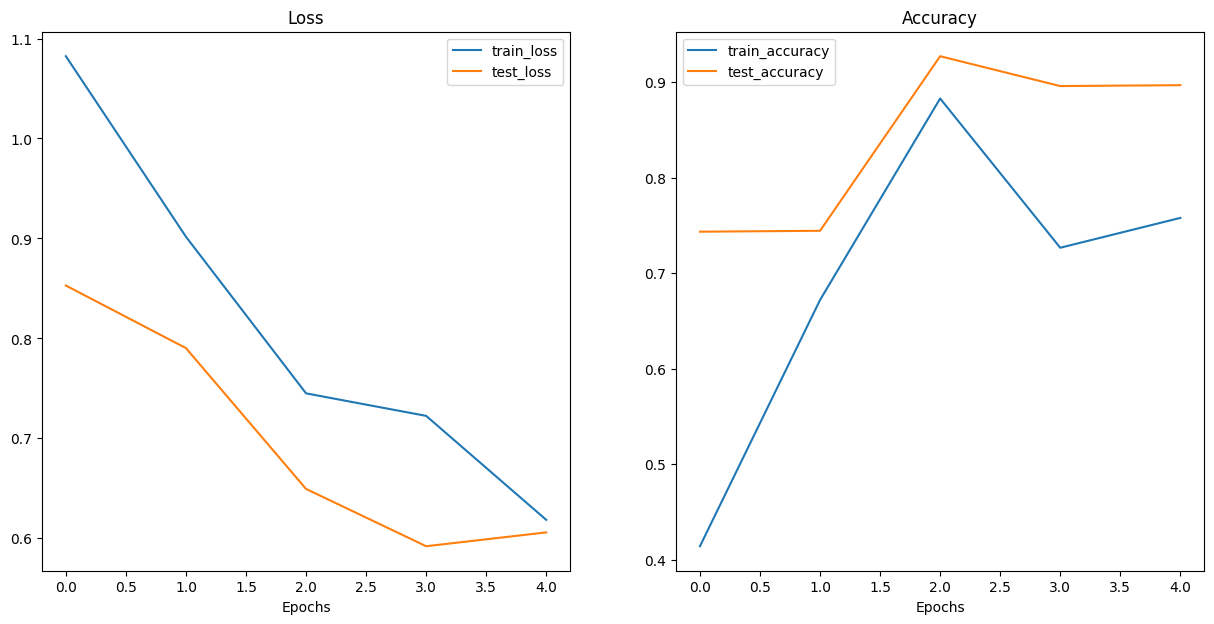

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [ ]:
from typing import List,Tuple
from PIL import Image
from torchvision import transforms

#1. Take in a trained model...
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size:Tuple[int, int]=(224,224),
                        transform: torchvision.transforms=None,
                        device:torch.device=device):
  #2. Open the image with PIL
  img=Image.open(image_path)

  #3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform=transform
  else:
    image_transform= transforms.Compose([transforms.Resize(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

  ### Predict on image ###
  #4.Make sure the model is on the target device
  model.to(device)

  #5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    #6.Transform the image and add an extra batch dimension
    transformed_image=image_transform(img).unsqueeze(dim=0)# [batch_size, color_channels, height, width]

    #7. Make a prediction on the transformed image by passing it to model
    target_image_pred=model(transformed_image.to(device))

  #8. Convert the model's output logits to pred probs
  target_image_pred_probs=torch.softmax(target_image_pred,dim=1)

  #9. Convert pred probs to classes
  target_image_pred_label=torch.argmax(target_image_pred_probs,dim=1)

  #10. PLot image with predicted label and prbability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

In [ ]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

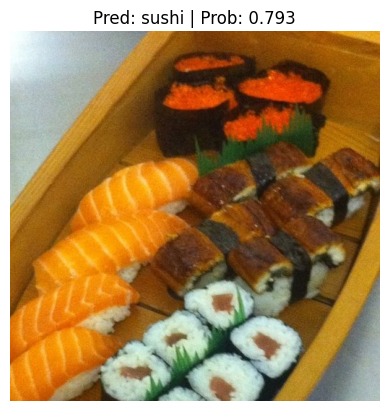

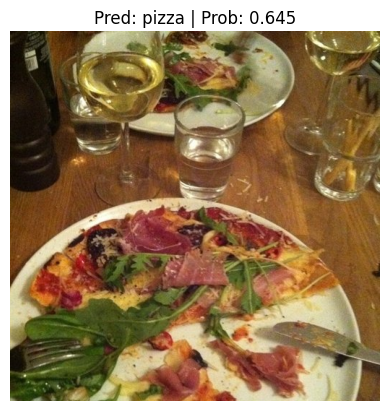

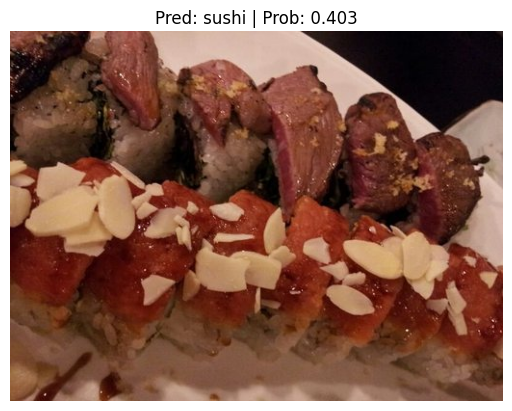

In [ ]:
#Get a random list of image paths from the test set
import random
num_images_to_plot=3
test_image_path_list=list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample=random.sample(population=test_image_path_list,
                                     k=num_images_to_plot)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

#Making predictions on a custom image

In [ ]:
#Download the image
import requests

#SEtup custom image path
custom_image_path=data_path/"04-pizza-dad.jpeg"

#Download the image if the image does not exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:

    #Download image from github with raw link
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}..")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists..")


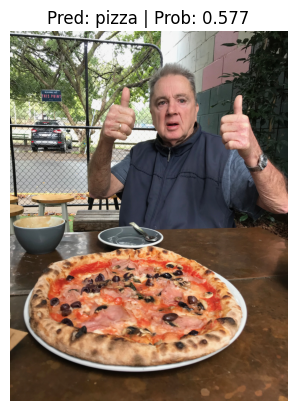

In [ ]:
#predict on the coston image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)